### Import Packages

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
#sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
RANDOM_SEED = np.random.seed(0)

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from datetime import datetime, timedelta, timezone

from prophet import Prophet
import altair as alt
#alt.renderers.enable('notebook')

Importing plotly failed. Interactive plots will not work.


### Import Data

In [2]:
data = pd.read_csv('pune_aqm_2020Oct_2022July_TimeSynched.csv')
data = data.drop('Unnamed: 0', axis=1)

### Initialize variables to get Date-Time object for Sensor Measurements for every 15 min interval

In [4]:
start_date = '2020-10-16'# 00:00:00+05:30'
date_format_str = '%Y-%m-%d'# %H:%M:%S%z'
end_date = '2022-07-20'# 00:00:00+05:30'
d0 = datetime.strptime(start_date, date_format_str)
d1 = datetime.strptime(end_date, date_format_str)
diff = d1-d0
sampling_frequency = 0.25
end_slot = start_date
start_slot = datetime.strptime(start_date, date_format_str)

### Get Date-Time object for Sensor Measurements for every 15 min interval

In [5]:
DateTime = start_slot
for j in range(int(diff.days*24*(1/sampling_frequency))):
    end_slot = start_slot+timedelta(hours = sampling_frequency)
    start_slot = end_slot
    DateTime = np.append(DateTime, start_slot)

### Exception to execute larger datasets

In [55]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Function to Fit Prophet Model to the Data

In [6]:
def fit_predict_model(dataframe, interval_width = 1, changepoint_range = 1):
    m = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

## Function to Detect Anomalies

In [7]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

## Function to Plot Anomalies

In [21]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='PM2.5'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='PM2.5'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

### Perform Test Run for Visualization

In [34]:
sensor = 44
single_sensor = pd.DataFrame()
single_sensor['DateTime'] = DateTime[57000:60000]
single_sensor['pm2p5'] = data.iloc[sensor,57000:60000].values
single_sensor.set_index('DateTime', inplace = True)
single_sensor_intp = single_sensor.interpolate(method = 'linear' , limit_direction = 'both',limit_area = None)
day_data = single_sensor_intp.iloc[:, :]
t = pd.DataFrame()
t['ds'] = day_data.index
t['y'] = day_data['pm2p5'].values
pred = fit_predict_model(t)
pred = detect_anomalies(pred)
plot_anomalies(pred)

23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:35 - cmdstanpy - INFO - Chain [1] done processing


alt.LayerChart(...)

## Run Prophet algorithm on all the sensors

In [76]:
for i in range(50):
    print("sensor ", i)
    single_sensor = pd.DataFrame()
    single_sensor['DateTime'] = DateTime[:-1]
    single_sensor['pm2p5'] = data.iloc[i,:].values
    single_sensor.set_index('DateTime', inplace = True)
    single_sensor_intp = single_sensor.interpolate(method = 'linear' , limit_direction = 'both',limit_area = None)
    day_data = single_sensor_intp.iloc[:, :]
    t = pd.DataFrame()
    t['ds'] = day_data.index
    t['y'] = day_data['pm2p5'].values
    pred = fit_predict_model(t)
    pred = detect_anomalies(pred)
    data.iloc[i,pred[pred['anomaly'] != 0].index] = np.nan

sensor  0


01:48:57 - cmdstanpy - INFO - Chain [1] start processing
01:49:14 - cmdstanpy - INFO - Chain [1] done processing


sensor  1


01:49:29 - cmdstanpy - INFO - Chain [1] start processing
01:49:45 - cmdstanpy - INFO - Chain [1] done processing


sensor  2


01:49:59 - cmdstanpy - INFO - Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing


sensor  3


01:50:29 - cmdstanpy - INFO - Chain [1] start processing
01:50:41 - cmdstanpy - INFO - Chain [1] done processing


sensor  4


01:50:55 - cmdstanpy - INFO - Chain [1] start processing
01:51:10 - cmdstanpy - INFO - Chain [1] done processing


sensor  5


01:51:25 - cmdstanpy - INFO - Chain [1] start processing
01:51:34 - cmdstanpy - INFO - Chain [1] done processing


sensor  6


01:51:49 - cmdstanpy - INFO - Chain [1] start processing
01:52:02 - cmdstanpy - INFO - Chain [1] done processing


sensor  7


01:52:17 - cmdstanpy - INFO - Chain [1] start processing
01:52:31 - cmdstanpy - INFO - Chain [1] done processing


sensor  8


01:52:45 - cmdstanpy - INFO - Chain [1] start processing
01:53:00 - cmdstanpy - INFO - Chain [1] done processing


sensor  9


01:53:15 - cmdstanpy - INFO - Chain [1] start processing
01:53:26 - cmdstanpy - INFO - Chain [1] done processing


sensor  10


01:53:41 - cmdstanpy - INFO - Chain [1] start processing
01:54:01 - cmdstanpy - INFO - Chain [1] done processing


sensor  11


01:54:16 - cmdstanpy - INFO - Chain [1] start processing
01:54:32 - cmdstanpy - INFO - Chain [1] done processing


sensor  12


01:54:47 - cmdstanpy - INFO - Chain [1] start processing
01:55:06 - cmdstanpy - INFO - Chain [1] done processing


sensor  13


01:55:21 - cmdstanpy - INFO - Chain [1] start processing
01:55:38 - cmdstanpy - INFO - Chain [1] done processing


sensor  14


01:55:53 - cmdstanpy - INFO - Chain [1] start processing
01:56:09 - cmdstanpy - INFO - Chain [1] done processing


sensor  15


01:56:24 - cmdstanpy - INFO - Chain [1] start processing
01:56:40 - cmdstanpy - INFO - Chain [1] done processing


sensor  16


01:56:56 - cmdstanpy - INFO - Chain [1] start processing
01:57:13 - cmdstanpy - INFO - Chain [1] done processing


sensor  17


01:57:28 - cmdstanpy - INFO - Chain [1] start processing
01:57:46 - cmdstanpy - INFO - Chain [1] done processing


sensor  18


01:58:02 - cmdstanpy - INFO - Chain [1] start processing
01:58:19 - cmdstanpy - INFO - Chain [1] done processing


sensor  19


01:58:35 - cmdstanpy - INFO - Chain [1] start processing
01:58:51 - cmdstanpy - INFO - Chain [1] done processing


sensor  20


01:59:06 - cmdstanpy - INFO - Chain [1] start processing
01:59:21 - cmdstanpy - INFO - Chain [1] done processing


sensor  21


01:59:38 - cmdstanpy - INFO - Chain [1] start processing
01:59:56 - cmdstanpy - INFO - Chain [1] done processing


sensor  22


02:00:12 - cmdstanpy - INFO - Chain [1] start processing
02:00:26 - cmdstanpy - INFO - Chain [1] done processing


sensor  23


02:00:43 - cmdstanpy - INFO - Chain [1] start processing
02:00:58 - cmdstanpy - INFO - Chain [1] done processing


sensor  24


02:01:15 - cmdstanpy - INFO - Chain [1] start processing
02:01:32 - cmdstanpy - INFO - Chain [1] done processing


sensor  25


02:01:52 - cmdstanpy - INFO - Chain [1] start processing
02:02:07 - cmdstanpy - INFO - Chain [1] done processing


sensor  26


02:02:28 - cmdstanpy - INFO - Chain [1] start processing
02:02:44 - cmdstanpy - INFO - Chain [1] done processing


sensor  27


02:03:04 - cmdstanpy - INFO - Chain [1] start processing
02:03:21 - cmdstanpy - INFO - Chain [1] done processing


sensor  28


02:03:41 - cmdstanpy - INFO - Chain [1] start processing
02:03:58 - cmdstanpy - INFO - Chain [1] done processing


sensor  29


02:04:19 - cmdstanpy - INFO - Chain [1] start processing
02:04:35 - cmdstanpy - INFO - Chain [1] done processing


sensor  30


02:04:56 - cmdstanpy - INFO - Chain [1] start processing
02:05:10 - cmdstanpy - INFO - Chain [1] done processing


sensor  31


02:05:32 - cmdstanpy - INFO - Chain [1] start processing
02:05:48 - cmdstanpy - INFO - Chain [1] done processing


sensor  32


02:06:08 - cmdstanpy - INFO - Chain [1] start processing
02:06:27 - cmdstanpy - INFO - Chain [1] done processing


sensor  33


02:06:48 - cmdstanpy - INFO - Chain [1] start processing
02:07:13 - cmdstanpy - INFO - Chain [1] done processing


sensor  34


02:07:35 - cmdstanpy - INFO - Chain [1] start processing
02:07:51 - cmdstanpy - INFO - Chain [1] done processing


sensor  35


02:08:13 - cmdstanpy - INFO - Chain [1] start processing
02:08:33 - cmdstanpy - INFO - Chain [1] done processing


sensor  36


02:08:55 - cmdstanpy - INFO - Chain [1] start processing
02:09:13 - cmdstanpy - INFO - Chain [1] done processing


sensor  37


02:09:35 - cmdstanpy - INFO - Chain [1] start processing
02:09:50 - cmdstanpy - INFO - Chain [1] done processing


sensor  38


02:10:12 - cmdstanpy - INFO - Chain [1] start processing
02:10:34 - cmdstanpy - INFO - Chain [1] done processing


sensor  39


02:10:56 - cmdstanpy - INFO - Chain [1] start processing
02:11:14 - cmdstanpy - INFO - Chain [1] done processing


sensor  40


02:11:36 - cmdstanpy - INFO - Chain [1] start processing
02:11:50 - cmdstanpy - INFO - Chain [1] done processing


sensor  41


02:12:11 - cmdstanpy - INFO - Chain [1] start processing
02:12:27 - cmdstanpy - INFO - Chain [1] done processing


sensor  42


02:12:48 - cmdstanpy - INFO - Chain [1] start processing
02:13:12 - cmdstanpy - INFO - Chain [1] done processing


sensor  43


02:13:34 - cmdstanpy - INFO - Chain [1] start processing
02:13:52 - cmdstanpy - INFO - Chain [1] done processing


sensor  44


02:14:16 - cmdstanpy - INFO - Chain [1] start processing
02:14:33 - cmdstanpy - INFO - Chain [1] done processing


sensor  45


02:14:55 - cmdstanpy - INFO - Chain [1] start processing
02:15:14 - cmdstanpy - INFO - Chain [1] done processing


sensor  46


02:15:36 - cmdstanpy - INFO - Chain [1] start processing
02:15:53 - cmdstanpy - INFO - Chain [1] done processing


sensor  47


02:16:14 - cmdstanpy - INFO - Chain [1] start processing
02:16:33 - cmdstanpy - INFO - Chain [1] done processing


sensor  48


02:16:55 - cmdstanpy - INFO - Chain [1] start processing
02:17:12 - cmdstanpy - INFO - Chain [1] done processing


sensor  49


02:17:33 - cmdstanpy - INFO - Chain [1] start processing
02:17:55 - cmdstanpy - INFO - Chain [1] done processing


### Load Data with Different Interval Widths in Prophet Model

In [38]:
pune_aqm_syc_nooutliers = pd.read_csv('pune_aqm_2020Oct_2022July_TimeSynched_NoOutliers.csv')
pune_aqm_syc_nooutliers_99 = pd.read_csv('pune_aqm_2020Oct_2022July_TimeSynched_NoOutliers_99.csv')
pune_aqm_syc_nooutliers_100 = pd.read_csv('pune_aqm_2020Oct_2022July_TimeSynched_NoOutliers_100.csv')
pune_aqm_syc = pd.read_csv('pune_aqm_2020Oct_2022July_TimeSynched.csv')

### Plot Data with an Interval Widths of 95% in Prophet Model

Text(0, 0.5, 'PM 2.5 Values')

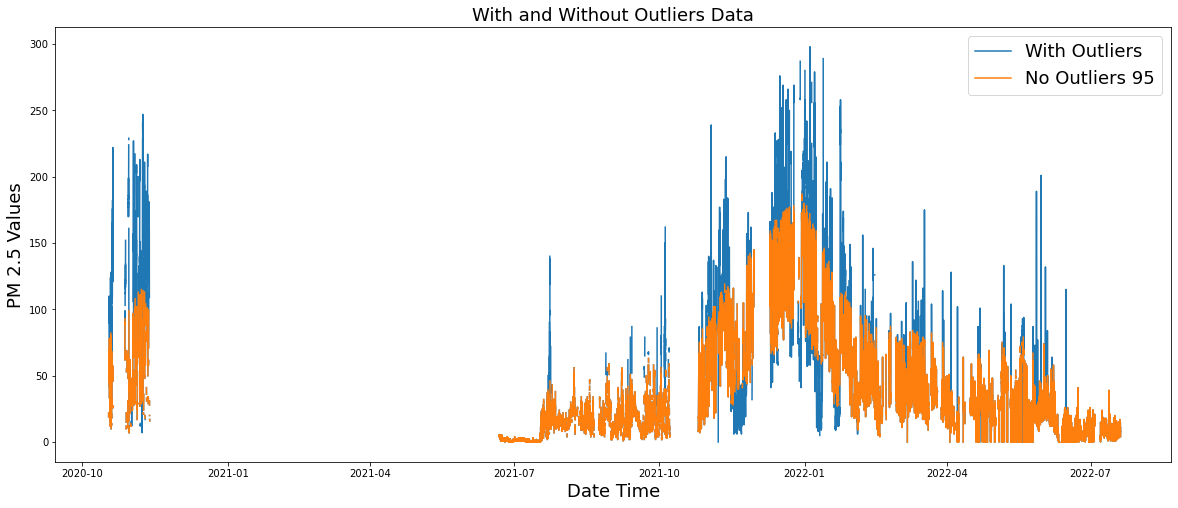

In [47]:
plt.figure(figsize=(20,8))
#plt.plot(sensor['observationDateTime'][31640:38550].values, sensor['pm2p5.avgOverTime'][31640:38550], label = 'Real Data')
plt.plot(DateTime[:], pune_aqm_syc.iloc[1,:], label = 'With Outliers')
plt.plot(DateTime[:], pune_aqm_syc_nooutliers.iloc[1,:], label = 'No Outliers 95')
#plt.plot(DateTime[:], pune_aqm_syc_nooutliers_100.iloc[2,:], label = 'No Outliers 100')
#plt.plot(DateTime[:], pune_aqm_syc_nooutliers_99.iloc[2,:], label = 'No Outliers 99')
#plt.plot(DateTime[begin:data_len], Testdata.iloc[begin:data_len, sensor].values, label = 'Test Data')
#plt.legend('Predicted Data','Actual Data','Test Data')
plt.legend(fontsize=18)
plt.title("With and Without Outliers Data", fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)
#plt.savefig('With_Vs_Without_Outliers_95_99_100_Data2.png', dpi = 300)

### Plot Data with Different Interval Widths in Prophet Model

Text(0, 0.5, 'PM 2.5 Values')

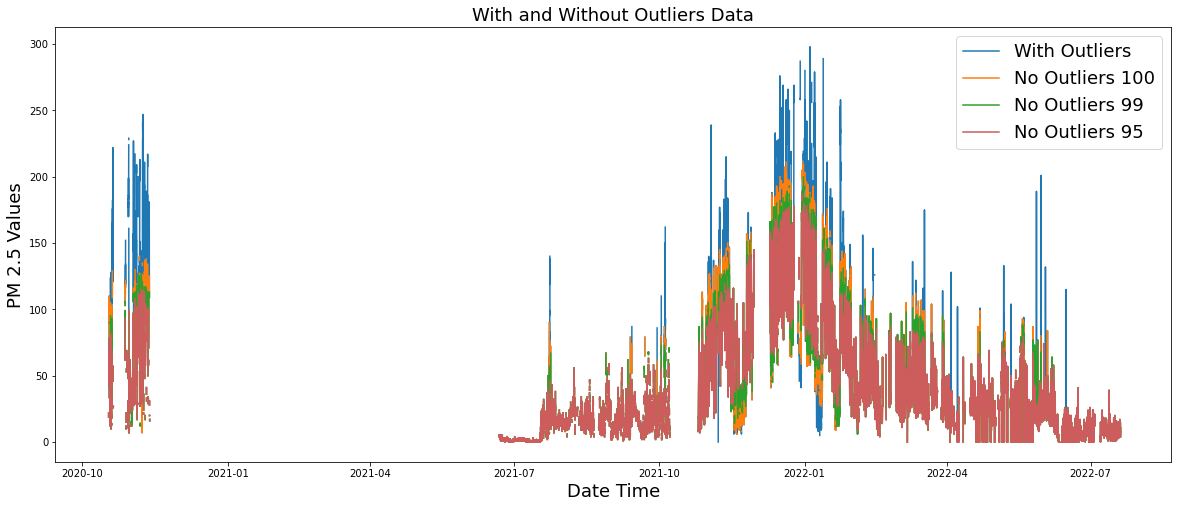

In [48]:
plt.figure(figsize=(20,8))
#plt.plot(sensor['observationDateTime'][31640:38550].values, sensor['pm2p5.avgOverTime'][31640:38550], label = 'Real Data')
plt.plot(DateTime[:], pune_aqm_syc.iloc[1,:], label = 'With Outliers')
plt.plot(DateTime[:], pune_aqm_syc_nooutliers_100.iloc[1,:], label = 'No Outliers 100')
plt.plot(DateTime[:], pune_aqm_syc_nooutliers_99.iloc[1,:], label = 'No Outliers 99')
plt.plot(DateTime[:], pune_aqm_syc_nooutliers.iloc[1,:], label = 'No Outliers 95',color='indianred')
#plt.plot(DateTime[begin:data_len], Testdata.iloc[begin:data_len, sensor].values, label = 'Test Data')
#plt.legend('Predicted Data','Actual Data','Test Data')
plt.legend(fontsize=18)
plt.title("With and Without Outliers Data",fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)
#plt.savefig('With_Vs_Without_Outliers_95_99_100_Data2.png', dpi = 300)